# Qwen2-1.5B-Instruct 指令微调

## 1 数据预处理

In [1]:
import os
import json


def dataset_jsonl_transfer(origin_path, new_path):
    """
    将原始数据集转换为大模型微调所需数据格式的新数据集
    """
    messages = []

    # 读取旧的JSONL文件
    with open(origin_path, "r") as file:
        for line in file:
            # 解析每一行的json数据
            data = json.loads(line)
            context = data["text"]
            catagory = data["category"]
            label = data["output"]
            message = {
                "instruction": "你是一个文本分类领域的专家，你会接收到一段文本和几个潜在的分类选项，请输出文本内容的正确类型",
                "input": f"文本:{context},类型选型:{catagory}",
                "output": label,
            }
            messages.append(message)

    # 保存重构后的JSONL文件
    with open(new_path, "w", encoding="utf-8") as file:
        for message in messages:
            file.write(json.dumps(message, ensure_ascii=False) + "\n")

In [2]:
# 加载、处理数据集和测试集
train_dataset_path = "./data/train.jsonl"
test_dataset_path = "./data/test.jsonl"

train_jsonl_new_path = "./data/train_processed.jsonl"
test_jsonl_new_path = "./data/test_processed.jsonl"

if not os.path.exists(train_jsonl_new_path):
    dataset_jsonl_transfer(train_dataset_path, train_jsonl_new_path)
if not os.path.exists(test_jsonl_new_path):
    dataset_jsonl_transfer(test_dataset_path, test_jsonl_new_path)

## 2 模型初始化

In [11]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

# -------------------------- Hugging Face加载本地模型 --------------------------
# 1. 加载Tokenizer（Qwen需启用trust_remote_code，use_fast=False适配中文）
tokenizer = AutoTokenizer.from_pretrained(
    "./models/Qwen2-1.5B-Instruct",
    use_fast=False,  # 禁用fast tokenizer，避免Qwen模型兼容问题
    trust_remote_code=True,  # 必须启用：Qwen的Tokenizer/Model是自定义实现
    padding_side="right",  # 生成任务需右padding（避免警告）
)
# 补充Qwen必要配置
tokenizer.eos_token_id = tokenizer.eos_token_id if tokenizer.eos_token_id else 151643
tokenizer.pad_token = tokenizer.eos_token  # 用eos_token作为pad_token
tokenizer.pad_token_id = tokenizer.eos_token_id  # 同步pad_token_id

# 2. 加载模型（自动适配GPU/CPU，bfloat16精度）
# 检测可用设备：优先GPU（支持CUDA），无则用CPU
if torch.cuda.is_available():
    # 有GPU：返回第一个可用GPU（cuda:0），并打印GPU信息
    device = torch.device("cuda")
    print(f"✅ 检测到GPU：{torch.cuda.get_device_name(0)}")
    print(f"   GPU数量：{torch.cuda.device_count()}")
    print(f"   设备编号：{device}")
else:
    # 无GPU：返回CPU
    device = torch.device("cpu")
    print("⚠️  未检测到GPU，使用CPU训练（速度较慢）")

# 配置精度：GPU支持bfloat16则用bfloat16，CPU用float32（CPU不支持bfloat16）
dtype = torch.bfloat16 if (torch.cuda.is_available() and torch.cuda.is_bf16_supported()) else torch.float32
print(f"最终 dtype: {dtype} (torch.{dtype})")

# ---------------------- 配置 BitsAndBytes 量化参数 ----------------------
# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=True,  # 开启4bit量化（显存最省，推荐）；需8bit则设为 load_in_8bit=True
#     bnb_4bit_quant_type="nf4",  # 量化类型：NF4（专为大模型设计，精度损失小）
#     bnb_4bit_compute_dtype=torch.bfloat16,  # 计算时的精度（用bfloat16，平衡速度和精度）
#     bnb_4bit_use_double_quant=True,  # 双量化（进一步降低显存占用，几乎不损失精度）
#     bnb_4bit_quant_storage_dtype=torch.float16,  # 量化参数的存储精度
# )

# 加载模型
model = AutoModelForCausalLM.from_pretrained(
    "./models/Qwen2-1.5B-Instruct",
    trust_remote_code=True,  # 必须启用：加载Qwen自定义模型结构
    # quantization_config=bnb_config,  # 传入量化配置
    torch_dtype=dtype,  # 自动适配精度
    device_map=device,  # 部署到检测到的设备
    low_cpu_mem_usage=True,  # 低CPU内存占用（加载大模型必备）
)
# 开启梯度检查点（训练时需用）
model.enable_input_require_grads()  # 开启梯度检查点时，要执行该方法

# （可选）验证模型加载成功
print("模型加载完成！")
print(f"Tokenizer vocab size: {tokenizer.vocab_size}")
print(f"Model device: {model.device}")

✅ 检测到GPU：NVIDIA GeForce RTX 2080 Ti
   GPU数量：1
   设备编号：cuda
最终 dtype: torch.bfloat16 (torch.torch.bfloat16)
模型加载完成！
Tokenizer vocab size: 151643
Model device: cuda:0


## 3 获取训练集

In [4]:
def process_func(example):
    """
    将数据集进行预处理
    """
    MAX_LENGTH = 384  # 序列最大长度（避免模型处理过长文本，适配显存）
    input_ids, attention_mask, labels = [], [], []

    # 第一步：构建“系统提示+用户输入”的指令模板（Qwen模型用`<|im_start|>`和`<|im_end|>`标记对话角色的开始和结束（固定格式））
    # - `system`角色：给模型设定身份（文本分类专家）和任务规则（输入文本+选项→输出正确类型）；
    # - `user`角色：输入内容是`example['input']`（原始数据中的“待分类文本+分类选项”）；
    # - `assistant\n`：表示接下来是模型需要生成的回复（即正确分类结果），作为生成的起始标记。
    instruction = tokenizer(
        f"""
        <|im_start|>system\n你是一个文本分类领域的专家，你会接收到一段文本和几个潜在的分类选项，请输出文本内容的正确类型<|im_end|>\n
        <|im_start|>user\n{example['input']}<|im_end|>\n
        <|im_start|>assistant\n""",
        add_special_tokens=False,  # 不自动添加特殊token（模板已手动加）
    )

    # 第二步：编码“正确分类结果”（模型需要学习生成的目标输出）
    response = tokenizer(f"{example['output']}", add_special_tokens=False)
    # `example['output']`是原始数据中的“正确分类标签”（如“体育”“科技”），编码为token ID。

    # 第三步：拼接输入序列（指令+正确回复），并添加终止符
    input_ids = instruction["input_ids"] + response["input_ids"] + [tokenizer.pad_token_id]
    # - `input_ids`：模型的输入token ID序列，由“指令编码 + 正确回复编码 + 终止符（pad_token_id）”组成；
    # - 用`pad_token_id`作为终止符（Qwen模型默认无eos_token，之前配置过`pad_token=eos_token`）。

    # 第四步：生成注意力掩码（告诉模型哪些token需要关注，哪些是无效的）
    attention_mask = (
        instruction["attention_mask"] + response["attention_mask"] + [1]
    )
    # - `attention_mask`与`input_ids`长度一致，1表示该token有效（需要关注），0表示无效（padding）；
    # - 指令和回复的token都是有效数据（掩码为1），终止符也视为有效（掩码为1）。

    # 第五步：生成训练标签（labels），实现“只训练回复部分”
    labels = [-100] * len(instruction["input_ids"]) + response["input_ids"] + [tokenizer.pad_token_id]  # 模型内部的 “自回归掩码” 自动实现错位
    # - `labels`是模型训练的目标序列，与`input_ids`长度一致；
    # - `-100`是PyTorch中CrossEntropyLoss的“忽略标记”：模型训练时会跳过`labels=-100`的位置，不计算损失；
    # - 指令部分（system+user）的`labels`设为-100：表示模型不需要学习生成指令，只需要学习生成“assistant”后的回复（分类结果）；
    # - 回复部分（`response["input_ids"]`）的`labels`是真实分类结果的token ID：模型需要学习预测这些token；
    # - 终止符的`labels`设为`pad_token_id`：让模型学习生成终止符后停止。

    # 第六步：截断超长序列（避免超过模型最大支持长度，导致报错）
    if len(input_ids) > MAX_LENGTH:  # 做一个截断
        input_ids = input_ids[:MAX_LENGTH]
        attention_mask = attention_mask[:MAX_LENGTH]
        labels = labels[:MAX_LENGTH]

    # 返回预处理后的三个核心字段（适配模型训练）
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

In [5]:
import pandas as pd
from datasets import Dataset

# 从JSONL文件读取训练数据（每行一个JSON对象，含input和output字段）
train_df = pd.read_json(
    train_jsonl_new_path,
    lines=True  # 告诉pd.read_json这是 JSONL 格式（每行一个 JSON）
)
print(train_df.shape)
# 转换为Hugging Face Dataset格式（适配transformers的Trainer类）
train_ds = Dataset.from_pandas(train_df)
# 对数据集应用预处理函数，删除原始字段（只保留训练所需的三个字段）
train_dataset = train_ds.map(  # 对train_ds中的每条数据应用process_func预处理，批量处理高效
    process_func,
    remove_columns=train_ds.column_names  # 删除原始的input和output字段，只保留预处理后的input_ids/attention_mask/labels，减少冗余。
)

(4000, 3)


Map: 100%|██████████| 4000/4000 [09:55<00:00,  6.72 examples/s]


## 4 训练配置

In [20]:
import sys
import types

# 1. 伪造 bitsandbytes.nn 模块（包含空的 Linear4bit 类）
fake_bnb_nn = types.ModuleType("bitsandbytes.nn")
# 定义空的 Linear4bit 类，让 hasattr(bnb.nn, "Linear4bit") 返回 True，但实际不使用
fake_bnb_nn.Linear4bit = type("Linear4bit", (), {})
fake_bnb_nn.Linear8bitLt = type("Linear8bitLt", (), {})  # 同时伪造 8bit 类

# 2. 伪造 bitsandbytes 主模块，包含 nn 子模块
fake_bnb = types.ModuleType("bitsandbytes")
fake_bnb.nn = fake_bnb_nn

# 3. 将伪造的模块注册到 sys.modules，让 Python 优先加载
sys.modules["bitsandbytes"] = fake_bnb
sys.modules["bitsandbytes.nn"] = fake_bnb_nn

# 4. 伪造 peft.tuners.lora.bnb 模块，避免导入报错
fake_peft_bnb = types.ModuleType("peft.tuners.lora.bnb")
# 定义空的 dispatch 函数，让 peft 调用时不报错
fake_peft_bnb.dispatch_bnb_8bit = lambda *args, **kwargs: None
fake_peft_bnb.dispatch_bnb_4bit = lambda *args, **kwargs: None
sys.modules["peft.tuners.lora.bnb"] = fake_peft_bnb

# 5. 强制覆盖 peft 的 is_bnb_available 函数，让它返回 True（但实际用伪造模块）
import peft.import_utils
peft.import_utils.is_bnb_available = lambda: True
peft.import_utils.is_bnb_4bit_available = lambda: True

In [ ]:
from transformers import (
    TrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq,
)
from peft import LoraConfig, TaskType, get_peft_model

config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    inference_mode=False,  # 训练模式
    r=8,  # Lora 秩
    lora_alpha=32,  # Lora alaph，具体作用参见 Lora 原理
    lora_dropout=0.1,  # Dropout 比例
)

model = get_peft_model(model, config)

args = TrainingArguments(
    output_dir="./outputs/Qwen2",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    logging_steps=10,
    num_train_epochs=2,
    save_steps=100,
    learning_rate=2e-4,
    save_on_each_node=True,
    gradient_checkpointing=True,
    # bfloat16=torch.cuda.is_available() and torch.cuda.is_bf16_supported(),  # 混合精度
    report_to="none",  # 禁用所有第三方监控（如wandb、tensorboard）
    # ---------------------- 新增：日志输出配置 ----------------------
    logging_dir="./outputs/Qwen2/logs",  # 日志文件保存路径（自动创建）
    logging_first_step=True,  # 打印第一步的损失（方便快速验证）
    logging_strategy="steps",  # 按“步数”输出日志（默认就是steps，可显式指定）
    log_level="info",  # 日志级别（确保指标被记录）
)

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,  # 传入模型，自动适配自回归逻辑
    padding=True,  # 动态Padding（省显存）
    max_length=384,  # 与你之前的序列长度一致
    label_pad_token_id=-100,  # Padding部分Labels设为-100（忽略损失）
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    data_collator=data_collator,
)

trainer.train()

/home/mm/miniconda3/envs/ykz/lib/python3.9/site-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/home/mm/miniconda3/envs/ykz/lib/python3.9/site-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
/home/mm/miniconda3/envs/ykz/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss
1,0.420700
10,0.491100
20,0.012300
30,5.416500
40,10.301700
50,0.870500
60,5.990300
70,0.114300
80,7.323500
90,2.955800


/home/mm/miniconda3/envs/ykz/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  
/home/mm/miniconda3/envs/ykz/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  
/home/mm/miniconda3/envs/ykz/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  
/home/mm/miniconda3/envs/ykz/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_lengt

TrainOutput(global_step=500, training_loss=2.6414179216725753, metrics={'train_runtime': 4725.4347, 'train_samples_per_second': 1.693, 'train_steps_per_second': 0.106, 'total_flos': 2.4322369388544e+16, 'train_loss': 2.6414179216725753, 'epoch': 2.0})

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

Curve saved as 'training_loss_curve.png'


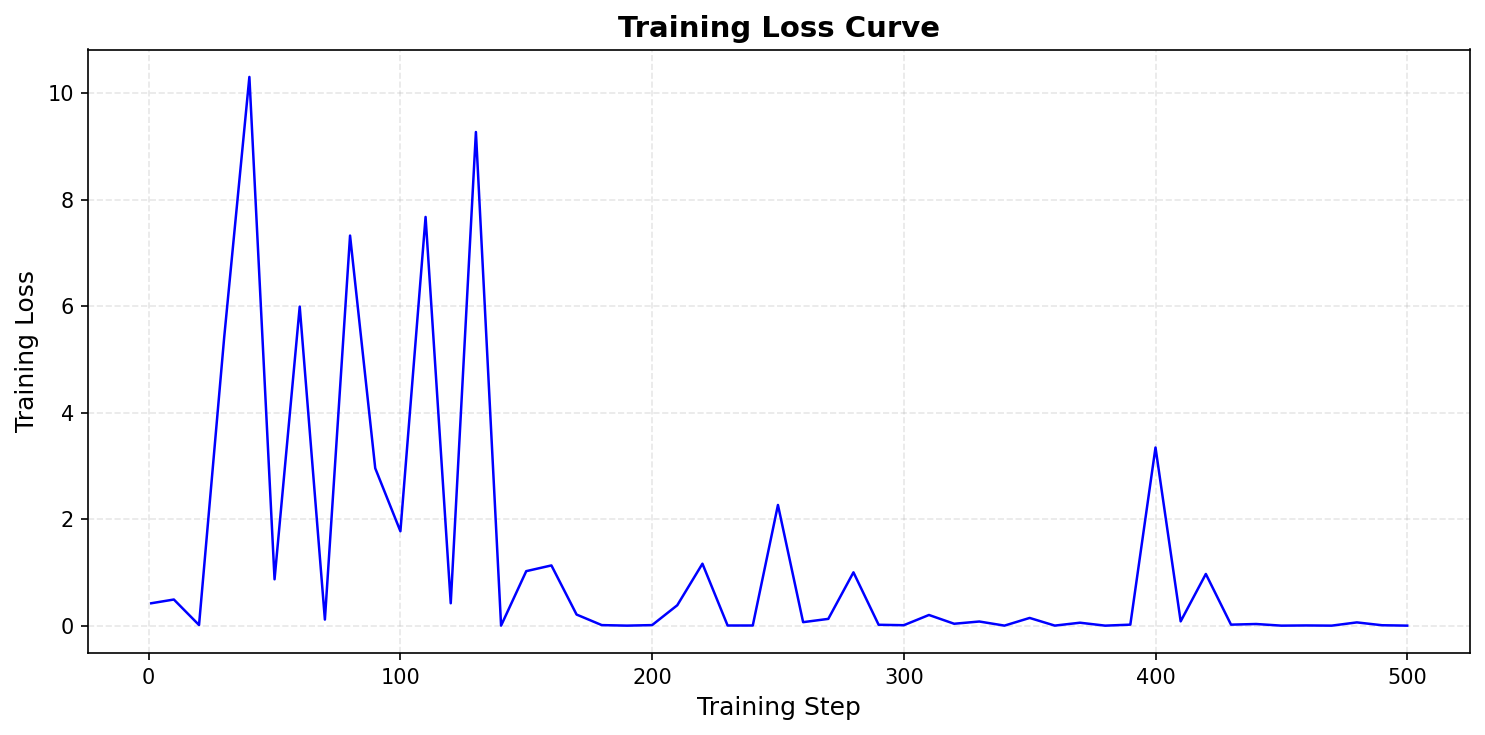

In [ ]:
import matplotlib.pyplot as plt

# 嵌入训练数据
steps = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
         110, 120, 130, 140, 150, 160, 170, 180, 190, 200,
         210, 220, 230, 240, 250, 260, 270, 280, 290, 300,
         310, 320, 330, 340, 350, 360, 370, 380, 390, 400,
         410, 420, 430, 440, 450, 460, 470, 480, 490, 500]

training_loss = [0.4207, 0.4911, 0.0123, 5.4165, 10.3017, 0.8705, 5.9903, 0.1143, 7.3235, 2.9558, 1.7728,
                 7.6734, 0.4209, 9.2681, 0.0009, 1.0236, 1.1311, 0.2087, 0.0107, 0.0008, 0.0107,
                 0.3834, 1.1634, 0.0032, 0.0032, 2.2662, 0.0660, 0.1275, 1.0013, 0.0169, 0.0087,
                 0.2009, 0.0361, 0.0782, 0.0010, 0.1452, 0.0014, 0.0556, 0.0005, 0.0192, 3.3447,
                 0.0807, 0.9707, 0.0193, 0.0312, 0.0006, 0.0042, 0.0006, 0.0615, 0.0081, 0.0007]

# 设置绘图样式（基础简洁版）
plt.figure(figsize=(10, 5))
plt.plot(steps, training_loss, color='blue', linewidth=1.2, marker='None')

# 设置标题和轴标签（英文）
plt.title('Training Loss Curve', fontsize=14, fontweight='bold')
plt.xlabel('Training Step', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)

# 添加网格（可选，增强可读性）
plt.grid(True, alpha=0.3, linestyle='--')

# 调整布局
plt.tight_layout()

# 保存图片（可选）
plt.savefig('training_loss_curve.png', dpi=150)
print("Curve saved as 'training_loss_curve.png'")

# 显示图片
plt.show()